In [30]:
# DEPS

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import matplotlib.pyplot as plt

In [118]:
#DATA

# train_dat = 81 cols, 1460 rows
train_dat = pd.read_csv('./train.csv')

# test_dat = 80 cols, 1459 rows
test_dat = pd.read_csv('./test.csv')

pd.options.display.max_columns = 100

In [3]:
# EVALUATION MEASURE

def log_rmse(y, yhat):
    diff_sq = (np.log(y) - np.log(yhat)) ** 2
    return (diff_sq.sum() / y.size) ** 0.5

In [4]:
# MODEL 1
# Predicting price as mean yields log_RMSE of 0.407565460399901 on training set

mean = train_dat.SalePrice.mean()
y = train_dat['SalePrice']
yhat = pd.Series(mean, index=test_dat.index)
error = log_rmse(y, yhat)
print('Error: {}'.format(error))

# Submit the model
test_dat['SalePrice'] = pd.Series(mean, index=test_dat.index)
test_dat[['Id', 'SalePrice']].to_csv('predict_the_mean.csv', index=False)

Error: 0.407565460399901


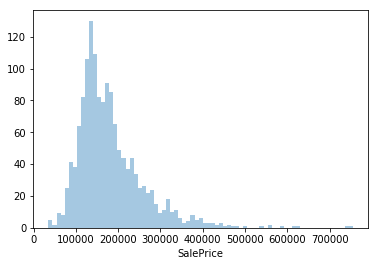

In [5]:
# EDA - what's the distribution of Sale Prices?

sns.distplot(train_dat['SalePrice'],bins=75, kde=False)

In [6]:
# Model 2
# Predicting price as median yields log_RMSE of 0.39994245028678643 on training set

median = train_dat.SalePrice.median()
y = train_dat['SalePrice']
yhat = pd.Series(median, index=test_dat.index)
error = log_rmse(y, yhat)
print('Error: {}'.format(error))

# Submit the model
test_dat['SalePrice'] = pd.Series(median, index=test_dat.index)
test_dat[['Id', 'SalePrice']].to_csv('predict_the_median.csv', index=False)

Error: 0.39994245028678643


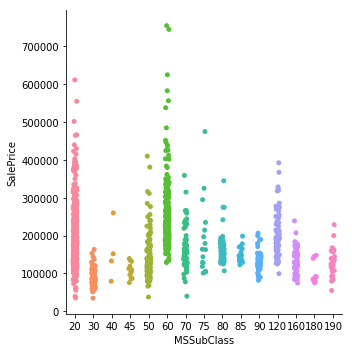

In [7]:
# EDA - Do properties of different types (MSSubClass) have different prices?

sns.catplot(x="MSSubClass", y="SalePrice", data=train_dat)


In [8]:
# Model 3 
# Predicting price as median of the MSSubClass to which the house belongs yields log_RMSE of 0.3323846436857664

groups = train_dat[['MSSubClass', 'SalePrice']].groupby('MSSubClass')
medians = groups.median()
y_hat = train_dat.apply(lambda p: medians.loc[p.loc['MSSubClass']][0], axis=1)
error = log_rmse(train_dat['SalePrice'], y_hat)
print('Error: {}'.format(error))

# Small hiccup - The MSSubClass value `150` is in the test set but not train set
# I can see there's only one property with this value:

#print(train_dat[['Id', 'MSSubClass']].groupby('MSSubClass').count())
#print(test_dat[['Id', 'MSSubClass']].groupby('MSSubClass').count())

# I'm filling it in with the global median.
medians.loc[150] = train_dat.SalePrice.median()

# Submit the model
y_hat = test_dat.apply(lambda p: medians.loc[p.loc['MSSubClass']][0], axis=1)
test_dat['SalePrice'] = y_hat
test_dat[['Id', 'SalePrice']].to_csv('predict_the_MSSubClass_median.csv', index=False)

Error: 0.3323846436857664


In [9]:
# Curiosity
# If you one hot encode the MSSubClass and do a linear regression (not using any other features)..
# - Q: how would you expect it to perform relative to using the median for each group (by MSSubClass)? 
# - A: almost identically: 0.332125001688164 vs 0.3323846436857664

y = train_dat['SalePrice'].values
y = y.reshape(y.size, -1)
X = pd.get_dummies(train_dat['MSSubClass']).values

regr = linear_model.LinearRegression()
regr.fit(X, y)
y_hat = regr.predict(X)
error = log_rmse(y, y_hat)

print('Error: {}'.format(error))

Error: 0.3321325881863102


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [10]:
# EDA - with a view to doing a simple regression
# Which features have values for every entry in train and test?
# Which features are categorical, which are continuous?

train_cols = train_dat.dropna(axis='columns').columns
test_cols = test_dat.dropna(axis='columns').columns
mutual_cols = train_cols.intersection(test_cols)
train_subs = train_dat[mutual_cols]
train_subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 47 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
LotArea          1460 non-null int64
Street           1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
ExterQual        1460 non-null object
ExterCond        1460 non-null object
Foundation       1460 non-null object
Heating          1460 non-null object
HeatingQC        1460 non-

*Referring to data_description.txt..*

###### CONTINUOUS
- LotArea          
- 1stFlrSF         
- 2ndFlrSF         
- LowQualFinSF     
- GrLivArea        
- FullBath         
- HalfBath         
- BedroomAbvGr     
- KitchenAbvGr     
- TotRmsAbvGrd     
- Fireplaces       
- WoodDeckSF       
- OpenPorchSF      
- EnclosedPorch    
- 3SsnPorch        
- ScreenPorch      
- PoolArea         
- MiscVal          
- *YrSold*
- *YearBuilt*
- *YearRemodAdd*

###### CATEGORICAL
- MSSubClass       
- Street           
- LotShape         
- LandContour      
- LotConfig        
- LandSlope        
- Neighborhood     
- Condition1       
- Condition2       
- BldgType         
- HouseStyle       
- OverallQual      
- OverallCond      
- RoofStyle        
- RoofMatl         
- ExterQual        
- ExterCond        
- Foundation       
- Heating          
- HeatingQC        
- CentralAir       
- PavedDrive       
- MoSold           


In [11]:
# MODEL 4 - Linear Regression with the continuous features which all have values
# Predict price using linear regression with the subset of features that don't require any engineering.

# For this model I will use only the continous variables and I will omit the *year* features; they need more thinking.
# - YrSold
# - YearBuilt
# - YearRemodAdd

col_names = ['LotArea', '1stFlrSF','2ndFlrSF','LowQualFinSF', 'GrLivArea', 'FullBath', \
             'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd', 'Fireplaces', \
             'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', \
             'PoolArea', 'MiscVal']
X = train_dat[col_names].values
y = train_dat['SalePrice'].values
y = y.reshape(y.size, 1)

regr = linear_model.LinearRegression()
regr.fit(X, y)
y_hat = regr.predict(X)
error = log_rmse(y, y_hat)
print('Error: {}'.format(error))

# Submit the model
y_hat = regr.predict(test_dat[col_names].values)
test_dat['SalePrice'] = y_hat
test_dat[['Id', 'SalePrice']].to_csv('simple_regression.csv', index=False)

Error: 0.21708975978691863


In [166]:
# MODEL 5 - Linear Regression with  continuous and categorical features.

# Problem 1
# ----------
# There are a few categorical features that share values:
# e.g: Condition1, Condition2 {Artery, Feedr, Norm, RRNn, RRAn, PosN, PosA, RRNe, RRAe}
# e.g: CentralAir, PavedDrive: {Y, N}

# Solution
# ---------
# I will namespace the new columns (from the one hot encoding) with their original column name
# to avoid collisions.

# Problem 2
# ----------
# (a) There are categorical features in the training set with values that do not appear in the test set.
# (b) There is a categorical feature in the test set with a value that do not appear in the training set.


# Solution
# --------
# (a) Add these columns to the test_set data with the zeros for values.
# (b) Add these columns to the training_set data with zeros for values.
# There is only one value revlevant to (b): The value of one house's MSSubClass of `150` doesn't appear in training.


# Solving Problem 1
# -----------------

def gen_one_hot(dat, cat_col_names):
    one_hots = [pd.get_dummies(dat[n]).add_prefix(n) for n in cat_col_names]
    return pd.concat(one_hots, axis=1) 

# Solving Problem 2
# -----------------

def gen_exclusive_cat_values(train, test, cat_col_names):
    one_hot_train = gen_one_hot(train, cat_col_names)
    one_hot_test = gen_one_hot(test, cat_col_names)
    train_not_test_cols = one_hot_train.columns.difference(one_hot_test.columns)
    test_not_train_cols = one_hot_test.columns.difference(one_hot_train.columns)
    return train_not_test_cols, test_not_train_cols

def impute_exclusive_cat_values(train, test, train_not_test_cols, test_not_train_cols):
    
    # training data: impute zeros for one hot cat cols that appear in test
    frames = [pd.DataFrame(0, columns=[c], index=train.index) for c in test_not_train_cols]
    train_fill_frame = None if len(frames) == 0 else pd.concat(frames, axis=1)
    
    # test data: impute zeros for one hot cat cols that appear in train
    frames = [pd.DataFrame(0, columns=[c], index=test.index) for c in train_not_test_cols]
    test_fill_frame = None if len(frames) == 0 else pd.concat(frames, axis=1)
    
    return train_fill_frame, test_fill_frame
    
def one_hotify_train(cont_col_names, cat_col_names):
    train_not_test_cols, test_not_train_cols = gen_exclusive_cat_values(train_dat, test_dat, cat_col_names)
    train_fill_frame, _ = impute_exclusive_cat_values(train_dat, test_dat, train_not_test_cols, test_not_train_cols)
    cont_cols = train_dat[cont_col_names]
    X = pd.concat([gen_one_hot(train_dat, cat_col_names), cont_cols, train_fill_frame ], axis=1)
    return X.reindex(sorted(X.columns),axis=1)
    
def one_hotify_test(cont_col_names, cat_col_names):
    train_not_test_cols, test_not_train_cols = gen_exclusive_cat_values(train_dat, test_dat, cat_col_names)
    _, test_fill_frame = impute_exclusive_cat_values(train_dat, test_dat, train_not_test_cols, test_not_train_cols)
    
    cont_cols = test_dat[cont_col_names]
    X = pd.concat([gen_one_hot(test_dat, cat_col_names), cont_cols, test_fill_frame], axis=1)
    return X.reindex(sorted(X.columns),axis=1)

cat_col_names = ['MSSubClass','Street', 'LotShape','LandContour', 'LotConfig','LandSlope', 'Neighborhood', \
                 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', \
                 'RoofMatl', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', \
                 'PavedDrive', 'MoSold']

cont_col_names = ['LotArea', '1stFlrSF','2ndFlrSF','LowQualFinSF', 'GrLivArea', 'FullBath', \
                  'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd', 'Fireplaces', \
                  'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', \
                  'PoolArea', 'MiscVal']

# regression - train
# ---------------------------
X = one_hotify_train(cont_col_names, cat_col_names)
y = train_dat['SalePrice'].values
regr = linear_model.LinearRegression()
regr.fit(X,y)
y_hat = regr.predict(X)
error = log_rmse(y, y_hat)
print('Error: {}'.format(error))

# regression - predict
# -----------------------------
X = one_hotify_test(cont_col_names, cat_col_names)
y_hat = regr.predict(X)

# regression - submit
# ---------------------------
test_dat['SalePrice'] = y_hat
test_dat[['Id', 'SalePrice']].to_csv('regression_with_one_hot_categoricals.csv', index=False)

Error: 0.13316009735988782


In [55]:
# What next?
# Some things I could work on..
# - ** I'm not using any of the *year* features (these have values for every row in both train and test)
# - I waved my hands a bit when filling in categorical variables that weren't in train/test in with zeros
# - I'm not using any features that don't have values for all rows in both train and test
# - I've not attempted to identify and remove anomalies from the dataset before training
# - I've not attempted to identify and remove redundant/dependent columns
# - I could use a funkier model than a linear regression..

                YrSold  YearBuilt  YearRemodAdd  SalePrice
YrSold        1.000000  -0.013618      0.035743  -0.028923
YearBuilt    -0.013618   1.000000      0.592855   0.522897
YearRemodAdd  0.035743   0.592855      1.000000   0.507101
SalePrice    -0.028923   0.522897      0.507101   1.000000


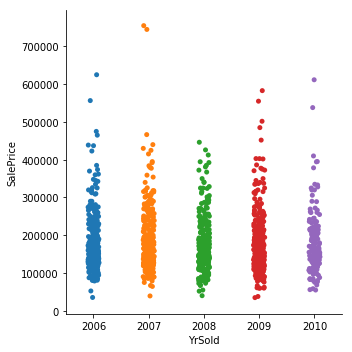

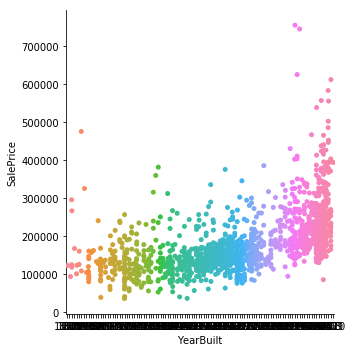

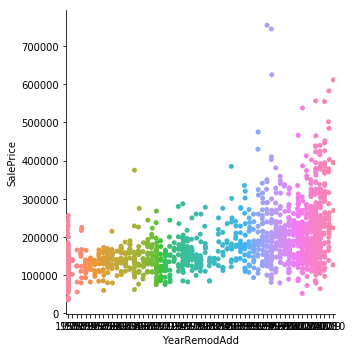

In [168]:
# EDA - *years* features

# YearRemodAdd and YearBuilt are strongly correlated with the SalePrice
# YrSold is not strongly correlated with the SalePrice
print(train_dat[['YrSold', 'YearBuilt', 'YearRemodAdd', 'SalePrice']].corr())

# There isn't much difference in distribution of SalePrice year to year
sns.catplot(x='YrSold', y='SalePrice', data=train_dat)

# YearBuilt correlation with SalePrice:
sns.catplot(x='YearBuilt', y='SalePrice', data=train_dat)
#print(train_dat['YearBuilt'].describe())

# YearRemodAdd correlation with SalePrice:
# There's an anomalous line of datapoints along y axis.
sns.catplot(x='YearRemodAdd', y='SalePrice', data=train_dat)


In [155]:
# MODEL 6 - Linear Regression with continuous and categorical features + years

cont_col_names = ['LotArea', '1stFlrSF','2ndFlrSF','LowQualFinSF', 'GrLivArea', 'FullBath', \
                  'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd', 'Fireplaces', \
                  'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', \
                  'PoolArea', 'MiscVal','YrSold', 'YearBuilt', 'YearRemodAdd']

cat_col_names = ['MSSubClass','Street', 'LotShape','LandContour', 'LotConfig','LandSlope', 'Neighborhood', \
                 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', \
                 'RoofMatl', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', \
                 'PavedDrive', 'MoSold']

# regression - train
# ---------------------------
X = one_hotify_train(cont_col_names, cat_col_names)
y = train_dat['SalePrice'].values
regr = linear_model.LinearRegression()
regr.fit(X,y)
y_hat = regr.predict(X)
error = log_rmse(y, y_hat)
print('Error: {}'.format(error))

# regression - predict
# ---------------------------
cont_cols = test_dat[cont_col_names]
#X = pd.concat([gen_one_hot(test_dat, cat_col_names), cont_cols, test_fill_frame], axis=1)
#X = X.reindex(sorted(X.columns),axis=1)
X = one_hotify_test(cont_col_names, cat_col_names)
y_hat = regr.predict(X)

# regression - submit
# ---------------------------
test_dat['SalePrice'] = y_hat
test_dat[['Id', 'SalePrice']].to_csv('regression_with_one_hot_categoricals_and_years.csv', index=False)

Error: 0.12827616685057144


In [99]:
# What next?
# Some things I could work on..
# - There are some anomalies in the *YearRemodAdd* feature
# - I waved my hands a bit when filling in categorical variables that weren't in train/test in with zeros
# - I'm not using any features that don't have values for all rows in both train and test
# - I've not attempted to identify and remove anomalies from the dataset before training
# - I've not attempted to identify and remove redundant/dependent columns
# - I could use a funkier model than a linear regression..
# - I've not considered special treatment for ordinal variables like: BsmtCond, BsmtExposure ..
# - ** OverallQual and OverallCond are [1,2 .. 10]; what happens if you treat them an continous rather than one-hotting?

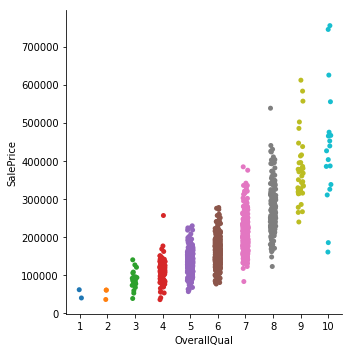

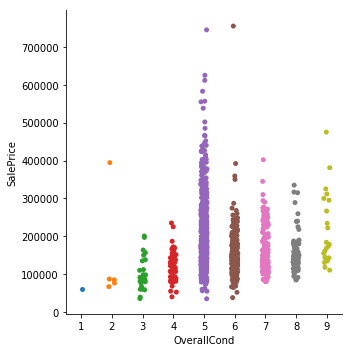

In [170]:
# EDA - OverallQual/Cond

# Perhaps unsurprisingly, quality and condition are pretty good predictors of SalePrice:
sns.catplot(x='OverallQual', y='SalePrice', data=train_dat)
sns.catplot(x='OverallCond', y='SalePrice', data=train_dat)

In [156]:
# MODEL 7 - Treating OverallQual/Cond as continuous rather than one-hot encoded categoricals

cont_col_names = ['LotArea', '1stFlrSF','2ndFlrSF','LowQualFinSF', 'GrLivArea', 'FullBath', \
                  'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd', 'Fireplaces', \
                  'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', \
                  'PoolArea', 'MiscVal','YrSold', 'YearBuilt', 'YearRemodAdd','OverallQual', 'OverallCond']

cat_col_names = ['MSSubClass','Street', 'LotShape','LandContour', 'LotConfig','LandSlope', 'Neighborhood', \
                 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', \
                 'RoofMatl', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', \
                 'PavedDrive', 'MoSold']

# regression - train
# ---------------------------
X = one_hotify_train(cont_col_names, cat_col_names)
y = train_dat['SalePrice'].values
regr = linear_model.LinearRegression()
regr.fit(X,y)
y_hat = regr.predict(X)
error = log_rmse(y, y_hat)
print('Error: {}'.format(error))

# regression - predict
# ---------------------------
cont_cols = test_dat[cont_col_names]
#X = pd.concat([gen_one_hot(test_dat, cat_col_names), cont_cols, test_fill_frame], axis=1)
#X = X.reindex(sorted(X.columns),axis=1)
X = one_hotify_test(cont_col_names, cat_col_names)
y_hat = regr.predict(X)

# Performs WORSE than previous model - not submitting.


Error: 0.14494913196604853


In [86]:
# What next?
# Some things I could work on..
# - There are some anomalies in the *YearRemodAdd* feature
# - I waved my hands a bit when filling in categorical variables that weren't in train/test in with zeros
# - ** I'm not using any features that don't have values for all rows in both train and test
# - I've not attempted to identify and remove anomalies from the dataset before training
# - I've not attempted to identify and remove redundant/dependent columns
# - I could use a funkier model than a linear regression..
# - I've not considered special treatment for ordinal variables like: BsmtCond, BsmtExposure ..

In [175]:
# EDA - which features do not have values for every entry in train and test?

# from ealier: getting columns with no null entries:
train_cols = train_dat.dropna(axis='columns').columns
test_cols = test_dat.dropna(axis='columns').columns
# columns used so far:
mutual_cols = train_cols.intersection(test_cols)
# columns not used so far:
unused_col_names = train_dat.columns.difference(mutual_cols)

print(train_dat[unused_col_names.drop(['SalePrice'])].info())
print(test_dat[unused_col_names.drop(['SalePrice'])].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 34 columns):
Alley           91 non-null object
BsmtCond        1423 non-null object
BsmtExposure    1422 non-null object
BsmtFinSF1      1460 non-null int64
BsmtFinSF2      1460 non-null int64
BsmtFinType1    1423 non-null object
BsmtFinType2    1422 non-null object
BsmtFullBath    1460 non-null int64
BsmtHalfBath    1460 non-null int64
BsmtQual        1423 non-null object
BsmtUnfSF       1460 non-null int64
Electrical      1459 non-null object
Exterior1st     1460 non-null object
Exterior2nd     1460 non-null object
Fence           281 non-null object
FireplaceQu     770 non-null object
Functional      1460 non-null object
GarageArea      1460 non-null int64
GarageCars      1460 non-null int64
GarageCond      1379 non-null object
GarageFinish    1379 non-null object
GarageQual      1379 non-null object
GarageType      1379 non-null object
GarageYrBlt     1379 non-null float64
KitchenQual    

*Referring to data_description.txt...*

###### CONTINUOUS
                
- BsmtFinSF1
- BsmtFinSF2
- BsmtFullBath
- BsmtHalfBath
- BsmtUnfSF
- GarageArea
- GarageCars
- GarageYrBlt
- LotFrontage
- MasVnrArea
- TotalBsmtSF

###### CATEGORICAL

- Alley
- BsmtCond
- BsmtExposure
- BsmtFinType1
- BsmtFinType2
- BsmtQual
- Electrical
- Exterior1st
- Exterior2nd
- Fence
- FireplaceQu
- Functional
- GarageCond
- GarageFinish
- GarageQual
- GarageType
- KitchenQual
- MSZoning
- MasVnrType
- MiscFeature
- PoolQC
- SaleType
- Utilities

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 2 columns):
GarageArea    1460 non-null int64
GarageCars    1460 non-null int64
dtypes: int64(2)
memory usage: 22.9 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 2 columns):
GarageArea    1458 non-null float64
GarageCars    1458 non-null float64
dtypes: float64(2)
memory usage: 22.9 KB


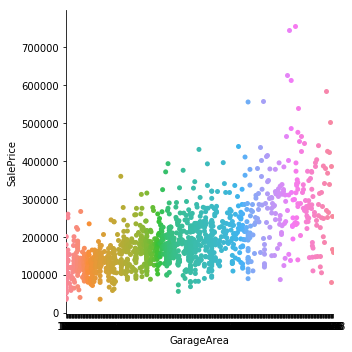

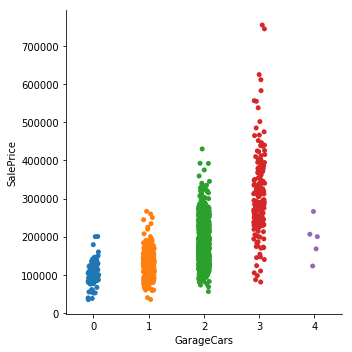

In [54]:
# EDA 
# - Which incomplete columns have predictive power?
# - How best to complete the incomplete continuous columns?

cont_incompl_col_names = ['BsmtFinSF1','BsmtFinSF2', 'BsmtFullBath','BsmtHalfBath', \
                         'BsmtUnfSF','GarageArea', 'GarageCars', 'GarageYrBlt' ,'LotFrontage', 'MasVnrArea','TotalBsmtSF']

# GarageArea and GarageCars are most strongly correlated with SalePrice
# I'll look at these two first.
train_dat[cont_incompl_col_names + ['SalePrice']].corr()
sns.catplot(x='GarageArea', y='SalePrice', data=train_dat)
sns.catplot(x='GarageCars', y='SalePrice', data=train_dat)

# Training data has values for these in every row.
# Test data is missing in one row.
train_dat[['GarageArea','GarageCars']].info()
test_dat[['GarageArea','GarageCars']].info()


In [157]:
# Filling GarageArea and GarageCars with null entries with the column mean

cont_col_names = ['LotArea', '1stFlrSF','2ndFlrSF','LowQualFinSF', 'GrLivArea', 'FullBath', \
                  'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd', 'Fireplaces', \
                  'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', \
                  'PoolArea', 'MiscVal','YrSold', 'YearBuilt', 'YearRemodAdd']

cat_col_names = ['MSSubClass','Street', 'LotShape','LandContour', 'LotConfig','LandSlope', 'Neighborhood', \
                 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', \
                 'RoofMatl', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', \
                 'PavedDrive', 'MoSold']

cont_incompl_col_names = ['GarageArea', 'GarageCars']

cont_incompl_cols = train_dat[cont_incompl_col_names]
cont_imputed_cols = cont_incompl_cols.fillna(cont_incompl_cols.mean())

X = one_hotify_train(cont_col_names, cat_col_names)
X = pd.concat([X, cont_imputed_cols], axis=1)
y = train_dat['SalePrice'].values
regr = linear_model.LinearRegression()
regr.fit(X,y)
y_hat = regr.predict(X)
error = log_rmse(y, y_hat)
print('Error: {}'.format(error))

# Small increase in performance: 0.12827616685057144 -> 0.12645734752327922
# I am going to do this to all the incomplete columns..

Error: 0.12645734752327922


In [158]:
# MODEL 8 - Filling all incomplete continous variables with null entries with their column mean

cont_col_names = ['LotArea', '1stFlrSF','2ndFlrSF','LowQualFinSF', 'GrLivArea', 'FullBath', \
                  'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd', 'Fireplaces', \
                  'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', \
                  'PoolArea', 'MiscVal','YrSold', 'YearBuilt', 'YearRemodAdd']

cat_col_names = ['MSSubClass','Street', 'LotShape','LandContour', 'LotConfig','LandSlope', 'Neighborhood', \
                 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', \
                 'RoofMatl', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', \
                 'PavedDrive', 'MoSold']

cont_incompl_col_names = ['BsmtFinSF1','BsmtFinSF2', 'BsmtFullBath','BsmtHalfBath', \
                         'BsmtUnfSF','GarageArea', 'GarageCars', 'GarageYrBlt', \
                          'LotFrontage', 'MasVnrArea','TotalBsmtSF']

cont_incompl_cols = train_dat[cont_incompl_col_names]
cont_imputed_cols = cont_incompl_cols.fillna(cont_incompl_cols.mean())

# regression - train
# ---------------------------
X = one_hotify_train(cont_col_names, cat_col_names)
X = pd.concat([X, cont_imputed_cols], axis=1)
y = train_dat['SalePrice'].values
regr = linear_model.LinearRegression()
regr.fit(X,y)
y_hat = regr.predict(X)
error = log_rmse(y, y_hat)
print('Error: {}'.format(error))

# regression - predict
# ---------------------------
cont_cols = test_dat[cont_col_names]
cont_incompl_cols = test_dat[cont_incompl_col_names]
cont_imputed_cols = cont_incompl_cols.fillna(cont_incompl_cols.mean())

#X = pd.concat([gen_one_hot(test_dat, cat_col_names), cont_cols], axis=1)
#X = pd.concat([X, cont_imputed_cols], axis=1)
#X = X.reindex(sorted(X.columns),axis=1)
X = one_hotify_test(cont_col_names, cat_col_names)
X = pd.concat([X, cont_imputed_cols], axis=1)
y_hat = regr.predict(X)

# regression - submit
# ---------------------------
test_dat['SalePrice'] = y_hat
test_dat[['Id', 'SalePrice']].to_csv('model8.csv', index=False)


Error: 0.11869573281372045


In [41]:
# What next?
# Some things I could work on..
# - There are some anomalies in the *YearRemodAdd* feature
# - I waved my hands a bit when filling in categorical variables that weren't in train/test in with zeros
# - I waved my hands a bit when filling in incomplete continous variables with their column means; try other strategies / look at their distribution to see if that made sense.
# - ** I'm not using any categorical features that don't have values for all rows in both train and test
# - I've not attempted to identify and remove anomalies from the dataset before training
# - I've not attempted to identify and remove redundant/dependent columns
# - I could use a funkier model than a linear regression..
# - I've not considered special treatment for ordinal variables like: BsmtCond, BsmtExposure ..

In [185]:
# MODEL 9 - Filling all incomplete categorical variables with null entries with their column mode

cont_col_names = ['LotArea', '1stFlrSF','2ndFlrSF','LowQualFinSF', 'GrLivArea', 'FullBath', \
                  'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd', 'Fireplaces', \
                  'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', \
                  'PoolArea', 'MiscVal','YrSold', 'YearBuilt', 'YearRemodAdd']

cat_col_names = ['MSSubClass','Street', 'LotShape','LandContour', 'LotConfig','LandSlope', 'Neighborhood', \
                 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', \
                 'RoofMatl', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', \
                 'PavedDrive', 'MoSold']

cont_incompl_col_names = ['BsmtFinSF1','BsmtFinSF2', 'BsmtFullBath','BsmtHalfBath', \
                         'BsmtUnfSF','GarageArea', 'GarageCars', 'GarageYrBlt', \
                          'LotFrontage', 'MasVnrArea','TotalBsmtSF']

cat_incompl_col_names = ['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'Electrical','Exterior1st', \
                         'Exterior2nd', 'Fence', 'FireplaceQu', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', \
                         'KitchenQual', 'MSZoning', 'MasVnrType', 'MiscFeature', 'PoolQC', 'SaleType', 'Utilities']

# regression - train
# ---------------------------

# Deal with cat incompl cols

cat_incompl_cols = train_dat[cat_incompl_col_names]
# curious that .mean() returns a series and .mode returns a dataframe
# having to access first row of return of mode() to get the series of interest.
cat_impute_cols = cat_incompl_cols.fillna(value=cat_incompl_cols.mode().loc[0])

# Get one hot fill frames for incomplete cat cols
train_not_test_cols, test_not_train_cols = gen_exclusive_cat_values(train_dat, test_dat, cat_incompl_col_names)
cat_incompl_train_fill_frame, cat_incompl_test_fill_frame = impute_exclusive_cat_values(train_dat, test_dat, train_not_test_cols, test_not_train_cols)
# and the one hot frame itself
one_hot_cat_incompl_frame = gen_one_hot(train_dat, cat_incompl_col_names)

# Same as done before, with addition of cat incompl cols

# Get one hot fill frames for cat cols
train_not_test_cols, test_not_train_cols = gen_exclusive_cat_values(train_dat, test_dat, cat_col_names)
train_fill_frame, test_fill_frame = impute_exclusive_cat_values(train_dat, test_dat, train_not_test_cols, test_not_train_cols)
# and the one hot frame itself
one_hot_cat_frame = gen_one_hot(train_dat, cat_col_names)

# cont frames
cont_cols = train_dat[cont_col_names]
cont_incompl_cols = train_dat[cont_incompl_col_names]
cont_imputed_cols = cont_incompl_cols.fillna(cont_incompl_cols.mean())

frames = [cat_incompl_train_fill_frame, one_hot_cat_incompl_frame, \
          train_fill_frame, one_hot_cat_frame, \
          cont_cols, cont_imputed_cols]

X = pd.concat(frames, axis=1)
X = X.reindex(sorted(X.columns),axis=1)
y = train_dat['SalePrice'].values
regr = linear_model.LinearRegression()
regr.fit(X,y)
y_hat = regr.predict(X)
error = log_rmse(y, y_hat)
print('Error: {}'.format(error))

# regression - predict
# ---------------------------

cat_incompl_cols = test_dat[cat_incompl_col_names]
# curious that .mean() returns a series and .mode returns a dataframe
# having to access first row of return of mode() to get the series of interest.
cat_impute_cols = cat_incompl_cols.fillna(value=cat_incompl_cols.mode().loc[0])

# the one hot frame itself - incompl
one_hot_cat_incompl_frame = gen_one_hot(test_dat, cat_incompl_col_names)
# the one hot frame itself 
one_hot_cat_frame = gen_one_hot(test_dat, cat_col_names)

# cont frames
cont_cols = test_dat[cont_col_names]
cont_incompl_cols = test_dat[cont_incompl_col_names]
cont_imputed_cols = cont_incompl_cols.fillna(cont_incompl_cols.mean())

frames = [cat_incompl_test_fill_frame, one_hot_cat_incompl_frame, \
          test_fill_frame, one_hot_cat_frame, \
          cont_cols, cont_imputed_cols]

X = pd.concat(frames, axis=1)
X = X.reindex(sorted(X.columns),axis=1)
y_hat = regr.predict(X)

# regression - submit
# ---------------------------
test_dat['SalePrice'] = y_hat
test_dat[['Id', 'SalePrice']].to_csv('model9.csv', index=False)

# This model scores 0.10473 on the training set and gets 0.21408 agaisnt the test set.
# That's the first time performance has increased on the training set and decreased on the test set.
# The model is likely overfitting.

Error: 0.10473606332109116


In [189]:
# EDA - why did performance increase on the training set and decrease on the test set?
# Q: what happens if you drop features which have large numbers of NANs: [PoolQC, MiscFeature, FireplaceQu, Fence, Alley]
# A: Training Set error: 0.10473 -> 0.10519, 
#    Test Set error: 0.21408 -> 0.19849

# This model scores 0.10473 on the training set and gets 0.21408 agaisnt the test set.
# That's the first time performance has increased on the training set and decreased on the test set.

# COPY AND PASTE FROM CELL ABOVE TO MESS AROUND WITH

cont_col_names = ['LotArea', '1stFlrSF','2ndFlrSF','LowQualFinSF', 'GrLivArea', 'FullBath', \
                  'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd', 'Fireplaces', \
                  'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', \
                  'PoolArea', 'MiscVal','YrSold', 'YearBuilt', 'YearRemodAdd']

cat_col_names = ['MSSubClass','Street', 'LotShape','LandContour', 'LotConfig','LandSlope', 'Neighborhood', \
                 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', \
                 'RoofMatl', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', \
                 'PavedDrive', 'MoSold']

cont_incompl_col_names = ['BsmtFinSF1','BsmtFinSF2', 'BsmtFullBath','BsmtHalfBath', \
                         'BsmtUnfSF','GarageArea', 'GarageCars', 'GarageYrBlt', \
                          'LotFrontage', 'MasVnrArea','TotalBsmtSF']

cat_incompl_col_names = ['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'Electrical','Exterior1st', \
                         'Exterior2nd', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', \
                         'KitchenQual', 'MSZoning', 'MasVnrType', 'SaleType', 'Utilities']

# regression - train
# ---------------------------

# Deal with cat incompl cols

cat_incompl_cols = train_dat[cat_incompl_col_names]
# curious that .mean() returns a series and .mode returns a dataframe
# having to access first row of return of mode() to get the series of interest.
cat_impute_cols = cat_incompl_cols.fillna(value=cat_incompl_cols.mode().loc[0])

# Get one hot fill frames for incomplete cat cols
train_not_test_cols, test_not_train_cols = gen_exclusive_cat_values(train_dat, test_dat, cat_incompl_col_names)
cat_incompl_train_fill_frame, cat_incompl_test_fill_frame = impute_exclusive_cat_values(train_dat, test_dat, train_not_test_cols, test_not_train_cols)
# and the one hot frame itself
one_hot_cat_incompl_frame = gen_one_hot(train_dat, cat_incompl_col_names)

# Same as done before, with addition of cat incompl cols

# Get one hot fill frames for cat cols
train_not_test_cols, test_not_train_cols = gen_exclusive_cat_values(train_dat, test_dat, cat_col_names)
train_fill_frame, test_fill_frame = impute_exclusive_cat_values(train_dat, test_dat, train_not_test_cols, test_not_train_cols)
# and the one hot frame itself
one_hot_cat_frame = gen_one_hot(train_dat, cat_col_names)

# cont frames
cont_cols = train_dat[cont_col_names]
cont_incompl_cols = train_dat[cont_incompl_col_names]
cont_imputed_cols = cont_incompl_cols.fillna(cont_incompl_cols.mean())

frames = [cat_incompl_train_fill_frame, one_hot_cat_incompl_frame, \
          train_fill_frame, one_hot_cat_frame, \
          cont_cols, cont_imputed_cols]

X = pd.concat(frames, axis=1)
X = X.reindex(sorted(X.columns),axis=1)
y = train_dat['SalePrice'].values
regr = linear_model.LinearRegression()
regr.fit(X,y)
y_hat = regr.predict(X)
error = log_rmse(y, y_hat)
print('Error: {}'.format(error))

# regression - predict
# ---------------------------

cat_incompl_cols = test_dat[cat_incompl_col_names]
# curious that .mean() returns a series and .mode returns a dataframe
# having to access first row of return of mode() to get the series of interest.
cat_impute_cols = cat_incompl_cols.fillna(value=cat_incompl_cols.mode().loc[0])

# the one hot frame itself - incompl
one_hot_cat_incompl_frame = gen_one_hot(test_dat, cat_incompl_col_names)
# the one hot frame itself 
one_hot_cat_frame = gen_one_hot(test_dat, cat_col_names)

# cont frames
cont_cols = test_dat[cont_col_names]
cont_incompl_cols = test_dat[cont_incompl_col_names]
cont_imputed_cols = cont_incompl_cols.fillna(cont_incompl_cols.mean())

frames = [cat_incompl_test_fill_frame, one_hot_cat_incompl_frame, \
          test_fill_frame, one_hot_cat_frame, \
          cont_cols, cont_imputed_cols]

X = pd.concat(frames, axis=1)
X = X.reindex(sorted(X.columns),axis=1)
y_hat = regr.predict(X)

# regression - submit
# ---------------------------
test_dat['SalePrice'] = y_hat
test_dat[['Id', 'SalePrice']].to_csv('model9.csv', index=False)


Error: 0.1051942735066285
